##### Question1 a

In RANDU, $x_{i+1} = 65539 \times x_{i}$ mod m, $u_i = x_i/ m$,  which $m = 2^{31}$

For the serial test, I simulate $2^{15}$ samples in total with the shape $2^{14} \times 2$ $(s = 2)$ dimensions, and considering them as two dimensional points. Then I participate the space $[0,1)^2$ into $64 = 8^2$ cells (small squares) of the same size, and count the number of 2-dimensional points in each cell ($N_j$). Finally, I build the statistic $\chi^2 = \sum_{j=1}^k \frac{(N_j - r/k)^2}{r/k}$

In [265]:
import numpy as np
import time
from scipy.stats import pareto
from scipy.stats import beta
import matplotlib.pyplot as plt


In [98]:
def randu(a = 65539, m = 2**31, N = 2**15, x0 = 5):
    x = np.zeros(N) # initialization 
    x[0] = x0       # the seed value
    u = np.zeros(N)
    for i in range(N-1):
        x[i+1] = (x[i] * a) % m
    u = x / m
    return u

In [99]:
def serialTest(u, r = 2**14, d = 8, k = 64):
    N = u.shape[0]
    num, _, _ = np.histogram2d(u[0:N:2], u[1:N:2], d, [[0,1],[0,1]]) 
    # Sliding the u and then determine how many points falling 
    #into the j-th cell.
    chi_sq = np.sum(np.power(num - (r/k), 2)/(r/k))
    return chi_sq

In [100]:
u = randu()
chi_sq = serialTest(u)
print("The Serial Test Statistic is " + str(chi_sq))

The Serial Test Statistic is 64.8984375


From the question, the degree of freedom for the chi-square distribution is 64-1 = 63, and the value of the serial statistic is around 64.90. By looking at the chi-square table, we know that $P(\chi^2 > 64.90) > 0.1$. Therefore, we cannot reject the $H_0$

##### Question1 b

In [101]:
np.random.seed(906)
u = np.random.uniform(0, 1, 2**15)
chi_sq = serialTest(u)
print("The Serial Test is " + str(chi_sq))

The Serial Test is 68.625


The numpy random is a random generator. I borrowed this generator to repeat the process. From the test above, the df is 63, and the chi_square value is 68.625. $P(\chi^2 > 68.625) = 0.292554 > 0.1$ by chi-square calculator, we can not reject the $H_0$

Ref: https://numpy.org/devdocs/reference/random/generator.html

##### Question2 

Algorithm: 1. Select two real numbers $a$ and $b$, and $a < b$. 2. Calculate their coressponding CDF $F(a)$ and $F(b)$. 3. Define a variable F(X) as $F(X) = \frac{Rand01()}{F(b) - F(a)} + F(a)$. 4. Calculate its corrresponding variable X by $X = F^{-1}(X)$

In [102]:
def Pareto_Dist(Lambda, alpha, x):
    F_x = 1- (Lambda/(Lambda + x))**alpha
    return F_x

In [103]:
def truncated_Dist(Lambda = 5, alpha = 2.5, a = 1, b = np.inf, N = 10000):
    F_a = pareto.cdf(a,alpha, -Lambda, Lambda)
    F_b = pareto.cdf(b, alpha, -Lambda,Lambda)
    F_X = np.random.uniform(F_a, F_b, N)
    X = pareto.ppf(F_X, alpha, -Lambda, Lambda)
    return X


In [104]:
a = 1
b = np.inf
Lambda = 5
alpha = 2.5
N = 10000
x = truncated_Dist(Lambda, alpha,a,b, N)

In [105]:
x

array([ 7.66820352,  2.75966024,  7.21713422, ...,  4.27138379,
       43.4148315 ,  1.84270954])

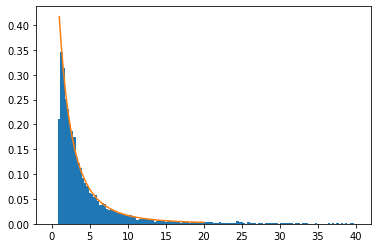

In [106]:
F_a = pareto.cdf(a,alpha, -Lambda, Lambda)
F_b = pareto.cdf(b, alpha, -Lambda,Lambda)
plt.figure()
plt.hist(x,density=True,bins=140,range=[0,40])
plt.plot(np.linspace(a,20,140), pareto.pdf(np.linspace(a,20,140), alpha, -Lambda, Lambda)/(F_b-F_a))
plt.show()

As we shown above, the histogram and the plot ot truncated pdf matches very well. Therefore, the fit is reasonable

##### Question3

$
\begin{split}
& do \\  
& \quad v_1,v_2 \leftarrow 2Rand01() - 1 \\ 
& while (v_1^2 + v_2^2) \geq 1 \\
&  X = v_1[-2ln(v_1^2 + v_2^2)]^{1/2}\\
& Y = v_2[-2ln(v_1^2 + v_2^2)]^{1/2}\\
& Return X,Y
\end{split}
$

In [253]:
from math import pi

In [254]:
def BoxMuller(N):
    N = N//2
    u1 = np.random.uniform(0,1,N)
    u2 = np.random.uniform(0,1,N)
    x1 = np.sqrt(-2*np.log(1-u1))*np.cos(2*pi*u2)
    x2 = np.sqrt(-2*np.log(1-u1))*np.sin(2*pi*u2)
    result = np.concatenate((x1,x2))
    return result

In [255]:
N = 1000000
x_box = BoxMuller(N)
print("The samples generated by Box Muller method is like")
print(x_box)

The samples generated by Box Muller method is like
[-1.42841852  2.7971935   0.38266982 ...  0.78063486 -1.6168186
 -0.94336434]


In [256]:
def Polar(N):
    v1 = 2*np.random.uniform(0,1,N//2)-1
    v2 = 2*np.random.uniform(0,1,N//2)-1
    Result = v1**2 + v2**2
    while any(Result)<1:
        indicies = np.where(Result <1)[0]
        n = len(indicies)
        result = np.zeros(n)
        v1_new = 2*np.random.uniform(0,1,n)-1
        v2_new = 2*np.random.uniform(0,1,n)-1
        result = v1_new**2 + v2_new**2
        Result[Result < 1] = result
        v1[Result < 1] = v1_new
        v2[Result < 1 ] = v2_new
    result = np.concatenate((v1,v2))
    return result
    

In [259]:
x_polar = Polar(N)
x_polar

array([ 0.97261399, -0.50870409,  0.24452883, ..., -0.91230714,
       -0.93500539, -0.58607893])

In [260]:
x_box_mean = np.mean(x_box)
x_box_var = np.sum(np.power(x_box-x_box_mean,2))/(N-1)
print("The sample mean for BoxMuller method is ", x_box_mean)
print("The sample variance for BoxMuller method is ", x_box_var)

The sample mean for BoxMuller method is  -5.396754746858417e-05
The sample variance for BoxMuller method is  0.9981213032536632


In [261]:
x_polar_mean = np.mean(x_polar)
x_polar_var = np.sum(np.power(x_polar-x_polar_mean,2))/(N-1)
print("The sample mean for polar method is ", x_polar_mean)
print("The sample variance for polar method is ", x_polar_var)

The sample mean for polar method is  -0.001124685359663456
The sample variance for polar method is  0.3331130693762763


In [262]:
start_time = time.time()
x = BoxMuller(N)
end_time = time.time()
print("The implementation time is used for CPU of BoxMuller Method")
print("--- %s seconds ---" % (end_time - start_time))

The implementation time is used for CPU of BoxMuller Method
--- 0.04288458824157715 seconds ---


In [263]:
start_time = time.time()
x = Polar(N)
end_time = time.time()
print("The implementation time is used for CPU of Polar Method")
print("--- %s seconds ---" % (end_time - start_time))

The implementation time is used for CPU of Polar Method
--- 0.03286933898925781 seconds ---


In my case, the polar method is a bit faster than the BoxMuller Method. Although there is a loop involved into the Polar method, I guess it probably because the simple calculation takes much less time than the loop. 

##### Question 4

The mode formula of beta distribution is $x_m = \frac{\alpha - 1}{\alpha + \beta -2}$ (source from Wikipedia). Applied $\alpha = 3, \beta= 4$, the mode $x_m = \frac{2}{5}=0.4$.    


To generate random variates with a pdf $\phi(x)$, we need to find the $t(x)$, which $t(x)\geq \phi(x)$. The pdf of beta distribution is $ x^{\alpha-1}(1-x)^{\beta-1} \times \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha) \Gamma(\beta)}$. Therefore, $\phi(x) \leq \frac{\Gamma(3+4)}{\Gamma(3)\Gamma(4)}(0.4)^{3-1}(0.6)^{4-1} = \frac{1296}{625}$ . Then we take $t(x) = \frac{1296}{625} $, and $r(x) = t(x) \frac{625}{1296} = 1$. 

From Page 8 of the slide, the Acceptance-Rejection needs to  generate $Y$ with density $r(x)$, then generate $U$ that are $Uniform (0,1)$. Finally, if $U \leq \phi(Y)/t(Y)$, then return $Y$, else go back to step 1 to generate another $Y$.

In [266]:
t = 1296/625
N = 10000
a = 3
b = 4

X = np.zeros(N)
Y = np.random.uniform(0,1,N)
U = np.random.uniform(0,1,N)
term = beta.pdf(Y, a, b)/t
X[U <= term] = Y[U <= term]
while any(X ==0):
    indicies = np.where(X == 0)[0]
    N = len(indicies)
    x = np.zeros(N)
    y = np.random.uniform(0,1,N)
    u = np.random.uniform(0,1,N)
    x[u <= beta.pdf(y, a, b)/t] = y[u <= beta.pdf(y, a, b)/t]
    X[X == 0] = x



In [267]:
print("Based on the Acceptance and Rejection, the generated samples are like below: ")
X

Based on the Acceptance and Rejection, the generated samples are like below: 


array([0.59657031, 0.30315012, 0.42101453, ..., 0.33553253, 0.6490395 ,
       0.34497319])

In [268]:
mean_estimated = np.mean(X)
var_estimated = np.power(X-mean_estimated, 2).sum()/(10000-1)
print("The sample mean and variance for acceptance and rejection method is ")
print(mean_estimated, "and", var_estimated)

The sample mean and variance for acceptance and rejection method is 
0.42733052270364713 and 0.030611894269141127


In [269]:
mean_theortical, var_theortical, _, _ = beta.stats(3, 4, moments='mvsk')
print("The theoretical mean and variance is ")
print(mean_theortical, "and", var_theortical)

The theoretical mean and variance is 
0.42857142857142855 and 0.030612244897959183


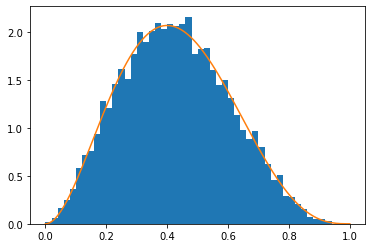

In [270]:
plt.figure()
plt.hist(X, density=True, bins=50, range=[0,1])
plt.plot(np.linspace(0,1,200), beta.pdf(np.linspace(0,1,200), 3, 4))
plt.show() 

As the plot shown above, the histogram and the plot of beta distribution matches very well. Therefore, the approximation is reasonable.

In [271]:
# convert the code above into the function 
def AcceptanceRejection(a,b,N,t):
    X = np.zeros(N)
    Y = np.random.uniform(0,1,N)
    U = np.random.uniform(0,1,N)
    term = beta.pdf(Y, a, b)/t
    X[U <= term] = Y[U <= term]
    while any(X ==0):
        indicies = np.where(X == 0)[0]
        N = len(indicies)
        x = np.zeros(N)
        y = np.random.uniform(0,1,N)
        u = np.random.uniform(0,1,N)
        x[u <= beta.pdf(y, a, b)/t] = y[u <= beta.pdf(y, a, b)/t]
        X[X == 0] = x
    return X

In [272]:
start_time = time.time()
x = AcceptanceRejection(a, b, N,t)
end_time = time.time()
print("The implementation time is used for CPU")
print("--- %s seconds ---" % (end_time - start_time))

The implementation time is used for CPU
--- 0.00200653076171875 seconds ---


The theoretical acceptance rate is the area under curve $\phi(x)$(pdf of $Beta(3,4)$) over area under curve $t(x) (f(x) = \frac{1296}{625})$, which is $\frac{625}{1296} \approx 0.482253$. The actual acceptance rate is like below

In [273]:
# convert the code above into the function 
def AcceptanceRejection_AccpetanceRate(a,b,N,t):
    count = N
    X = np.zeros(N)
    Y = np.random.uniform(0,1,N)
    U = np.random.uniform(0,1,N)
    term = beta.pdf(Y, a, b)/t
    X[U <= term] = Y[U <= term]
    while any(X ==0):
        indicies = np.where(X == 0)[0]
        N = len(indicies)
        count = count + N
        x = np.zeros(N)
        y = np.random.uniform(0,1,N)
        u = np.random.uniform(0,1,N)
        x[u <= beta.pdf(y, a, b)/t] = y[u <= beta.pdf(y, a, b)/t]
        X[X == 0] = x
    return (10000/count)

In [277]:
t = 1296/625
N = 10000
a = 3
b = 4
result = AcceptanceRejection_AccpetanceRate(a,b,N,t)
print("the accpetance rate is about ",result)

the accpetance rate is about  0.48049202383240436


##### Question4 b implement beta distribution in an alternative way

In [180]:
def orderBeta(a, b, N):
    u = np.random.uniform(0,1,(N,a+b-1)) # generate 10000*6 matrix
    x = np.sort(u, axis=1)[:, a-1] # since the index starts from 0
    return x

In [185]:
print("The generated samples are like below: ")
x = orderBeta(a, b, N)
x

The generated samples are like below: 


array([0.72460798, 0.07425979, 0.42164989, ..., 0.29396665, 0.32423545,
       0.47265004])

In [186]:
mean_estimated = np.mean(x)
var_estimated = np.power(x-mean_estimated, 2).sum()/(10000-1)
print("The sample mean and variance for acceptance and rejection method is ")
print(mean_estimated, "and", var_estimated)

The sample mean and variance for acceptance and rejection method is 
0.42661653839387226 and 0.030657933342572864


In [187]:
mean_theortical, var_theortical, _, _ = beta.stats(a, b, moments='mvsk')
print("The theoretical mean and variance is ")
print(mean_theortical, "and", var_theortical)

The theoretical mean and variance is 
0.42857142857142855 and 0.030612244897959183


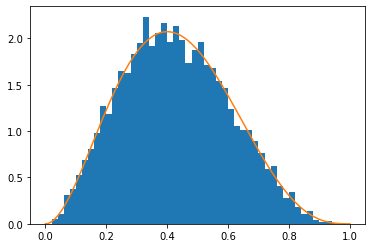

In [189]:
plt.figure()
plt.hist(x, density=True, bins=50, range=[0,1])
plt.plot(np.linspace(0,1,200), beta.pdf(np.linspace(0,1,200), 3, 4))
plt.show() 

The plot is like above, the histogram fits good with the real pdf function.

In [195]:
import time
start_time = time.time()
x = orderBeta(a, b, N)
end_time = time.time()
print("The implementation time is used for CPU")
print("--- %s seconds ---" % (end_time - start_time))

The implementation time is used for CPU
--- 0.0009970664978027344 seconds ---


The function in part (b) takes 0.0009970664978027344 seconds, but the function in part(a) takes 0.003956794738769531 seconds. Therefore, function in part(b) is faster.
The reason why b is faster is probably because there is a while loop involved in a. In part b, it takes a very minimum time to generate an 1000*6 matrix, and then we select the alpha-th in each row to make it a beta distribution. However, in part a, it actually needs more times to run in the loop because it is not guaranteed that the first time 10000 samples all satisfy the requirement. If it doesn't work, we need to resimulate the number again. 

##### Question 5

$
\begin{split}
Var(\hat{\mu}_{ant}) &= Var(\frac{2}{n}\sum_{i=1}^{\frac{n}{2}}\frac{f(\vec{u}_i) + f(-\vec{u}_i)}{2})
\end{split}
$

$
\begin{split}
f(\vec{u_i}) &= \sum_{j = 1}^{s}(0.5 - u_j)^2
\end{split}
$

$
\begin{split}
f(-\vec{u_i}) &= \sum_{j = 1}^{s}(0.5 - (1-u_j))^2\\
& = \sum_{j=1}^{s}(u_j - 0.5)^2\\
&=f(\vec{u_i})
\end{split}
$

$
\begin{split}
Var(\hat{\mu}_{ant}) &= Var(\frac{2}{n}\sum_{i=1}^{n/2}f(\vec{u}_i)) \\
&=\frac{2}{n}Var(f(\vec{u}_i))\\
\end{split}
$

$
\begin{split}
Var(\hat{\mu}_{mc}) &= Var(\frac{1}{n}\sum_{i=1}^{n}\sum_{j=1}^{s} (0.5-u_{ij})^2)\\
&= \frac{1}{n^2} \sum_{i=1}^{n} Var(\sum_{j=1}^{s} (0.5-u_{ij})^2)) \\
&= \frac{1}{n} Var(f(\vec{u_i}))
\end{split}
$


Therefore,
$\frac{Var(\hat{\mu}_{ant})}{Var(\hat{\mu}_{mc})} = 2$

Because $f(\vec{u}) = f(1-\vec{u}) = \sum_{j=1}^{s} (0.5-(1-u_j))^2 = \sum_{j=1}^{s} (0.5-u_j)^2 = f(\vec{u})$. Therefore, the covariance is 1. However, from the lectrue note, the variance of the estimator will reduce under the condition that the covariance is $Cov(f(\textbf{u}), f(\tilde{\textbf{u}})) < 0$. Therefore, obviously the variance of the estimator will increase. 

##### Question 6

I used the standard recursive method to simulate the stock price, where $S_i(t_j) = S_i(t_{j-1})e^{(r-\sigma^2/2)\delta + \sigma \sqrt{\delta} Z_{ij}}$, and $i = 1, 2, ..., n$, $j = 1, 2, ..., 10$, $Z_{ij}s$ are i.i.d. $\sim Normal(0,1) $. Then compute the estimated option price using $C = \frac{1}{n} \sum_{i=1}^n e^{-rT} max\{0, \frac{1}{s}\sum_{j=1}^{s}S_i(t_j) - K\}$   

The result of the program is like below:

In [236]:
r = 0.04
T = 1
sigma = 0.35
S_0 = 50
K = 45
s = 10
N = 10000
def AsianCallOption(r, T, sigma, s, S_0, K, N):
    delta = T/s
    S_t = np.zeros((N, s+1))
    S_t[:,0] = S_0
    for i in range(s):
        W_t = np.random.normal(0,1,N)
        S_t[:,i+1] = S_t[:,i] * np.exp( (r-sigma**2/2)*delta+ sigma * np.sqrt(delta) * W_t)
    payoff = np.mean(S_t[:,1:], axis=1) - K 
    payoff[payoff < 0 ] = 0
    price = np.mean(np.exp(-r *T)*payoff )
    var = np.sum(np.power(payoff - price, 2))/(N-1)/N
    return price,var

In [237]:
price_MC,var_MC = AsianCallOption(r, T, sigma, s, S_0, K, N)
price_MC

7.607989643154084

In [238]:
print("The estimated price call option by naive Monte Carlo is ", price)

The estimated price call option by naive Monte Carlo is  7.534876472151371


In [241]:
def AsianCallOption2(r, T, sigma, s, S_0, K, N):
    delta = T/s
    num = N//2
    S_t = np.zeros((N, s+1))
    S_t[:,0] = S_0
    for i in range(s):
        W_t = np.random.normal(0,1,int(N/2))
        S_t[0:num,(i+1)] = S_t[0:num,i] * np.exp( (r-sigma**2/2) * delta + sigma * np.sqrt(delta)* W_t)
        S_t[num:,(i+1)] = S_t[num:,i]*np.exp( (r-sigma**2/2) * delta + sigma* np.sqrt(delta)*(- W_t))
    payoff = np.exp(-r*T)* (np.mean(S_t[:,1:], axis=1) - K) 
    payoff[payoff < 0] = 0
    price = np.mean((payoff[0:num] + payoff[num:])/2)
    var = np.sum(np.power(payoff-price, 2))/(N/2-1)/(N/2)
    return price,var

In [242]:
price_AV,var_AV = AsianCallOption2(r, T, sigma, s, S_0, K, N)
price_AV

7.528403002395149

In [243]:
print("The estimated price call option by Antithetic Variates is ", price)

The estimated price call option by Antithetic Variates is  7.534876472151371


In [244]:
print("The variance of Monte Carlo is ", var_MC)

The variance of Monte Carlo is  0.009093266016597061


In [245]:
print("The variance of the Antithetic Variate is ", var_AV)

The variance of the Antithetic Variate is  0.031946214968765464


In [249]:
start_time = time.time()
price_MC,var_MC = AsianCallOption(r, T, sigma, s, S_0, K, N)
end_time = time.time()
time_MC = end_time - start_time
print("The implementation time is used for CPU")
print("--- %s seconds ---" % (end_time - start_time))

The implementation time is used for CPU
--- 0.00698089599609375 seconds ---


In [250]:
start_time = time.time()
price_MC,var_MC = AsianCallOption2(r, T, sigma, s, S_0, K, N)
end_time = time.time()
time_AV = end_time - start_time
print("The implementation time is used for CPU")
print("--- %s seconds ---" % (end_time - start_time))

The implementation time is used for CPU
--- 0.0059854984283447266 seconds ---


By using the formula to estimate the efficieny  

$$Eff(\hat{\mu}) = \frac{1}{MSE(\hat{\mu})\times C(\hat{\mu})}$$

In [251]:
Efficiency_a = 1/(var_MC*time_MC)
Efficiency_b = 1/(var_AV*time_AV)
Efficiency_a, Efficiency_b

(4543.863140997618, 5229.742059093211)

Method B has a higher efficiency than Method A